In [1]:
from __future__ import print_function, division

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dropout, Dense, Activation, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import AveragePooling2D
from keras import optimizers
from keras import initializers
from keras import regularizers
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
from keras.callbacks import ModelCheckpoint

In [4]:
from keras.datasets import cifar10

# 10 classes for cifar10.
nb_classes = 10

# Download and load the data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert to float datatype.
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Normalize so the max value is 1.
X_train /= 255
X_test /= 255

# Change to 1-hot encoding.
Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

In [5]:
# Check our shapes.
print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


In [6]:
# Subtract by the mean pixel, so image data is centered around 0.
# This differs from the paper in which, 
# "images were whitened and contrast normalized following Goodfellow et al. (2013)."
mean_px = X_train.mean(axis=0).mean(axis=0).mean(axis=0)
X_train -= mean_px

In [26]:
from keras.layers import Convolution2D

In [27]:
?Convolution2D

In [34]:
def conv(x, nb_filters, kernel_size=(3,3), strides=(1,1), padding='same', 
         kernel_initializer=initializers.he_uniform(),  # Not sure how weights were initialized.
         kernel_regularizer=regularizers.l2(0.001),  # "all models were regularized with weight decay \lambda=0.001"
         activation='relu',  # Table 1,2    
        ):
    """Convolutional layer"""

    x = Conv2D(nb_filters, kernel_size=kernel_size, strides=strides, 
           padding=padding, kernel_initializer=kernel_initializer, 
           kernel_regularizer=kernel_regularizer, activation=activation)(x)

    return x

In [35]:
import keras.backend as K

In [76]:
# Clear session since keras keeps the graph in memory.
K.clear_session()

# Model C from Table 1 and 2.
inputs = Input(shape=(32, 32, 3))
x = Dropout(0.2)(inputs) # "dropout probabilities were 20% for dropping out inputs ..."

x = conv(x, 96)
x = conv(x, 96)
x = conv(x, 96, strides=(2,2))
x = Dropout(0.5)(x)  # "dropout ... after the layer replacing the pooling layer ... and 50% ..."

x = conv(x, 192)
x = conv(x, 192)
x = conv(x, 192, strides=(2,2))
x = Dropout(0.5)(x)

x = conv(x, 192)
x = conv(x, 192, kernel_size=(1,1), padding='valid')
x = conv(x, nb_filters=nb_classes, kernel_size=(1,1), padding='valid')

x = GlobalAveragePooling2D()(x)
preds = Activation('softmax')(x)

model = Model(inputs=inputs, outputs=preds)
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       166080    
__________

In [78]:
checkpointer = ModelCheckpoint(filepath="all-conv-weights.hdf5", verbose=0, save_best_only=True, monitor='val_acc')
tb = TensorBoard(log_dir='/local-scratch/jer/projects/ex_keras/logs', histogram_freq=0, write_graph=False, write_images=False)
history = model.fit(X_train[:1000], Y_train[:1000], epochs=5, validation_split=0.2, shuffle=True, verbose=2, callbacks=[checkpointer, tb])

Train on 800 samples, validate on 200 samples
Epoch 1/5
25s - loss: 4.7541 - acc: 0.0938 - val_loss: 4.6437 - val_acc: 0.0850
Epoch 2/5
25s - loss: 4.5370 - acc: 0.1063 - val_loss: 4.4227 - val_acc: 0.0850
Epoch 3/5
24s - loss: 4.3198 - acc: 0.1063 - val_loss: 4.2142 - val_acc: 0.0850
Epoch 4/5
23s - loss: 4.1265 - acc: 0.1063 - val_loss: 4.0319 - val_acc: 0.0850
Epoch 5/5
26s - loss: 3.9504 - acc: 0.1063 - val_loss: 3.8649 - val_acc: 0.0850


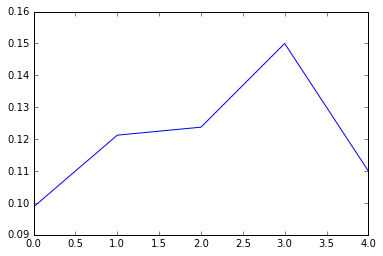

In [72]:
plt.plot(history.history['acc'])

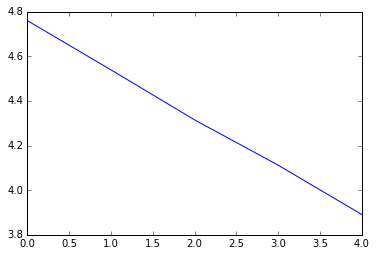

In [73]:
plt.plot(history.history['loss'])

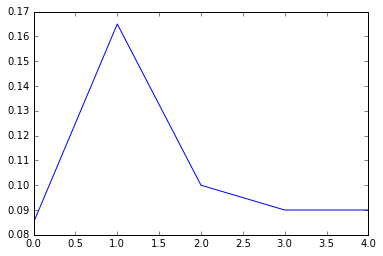

In [70]:
plt.plot(history.history['val_acc'])

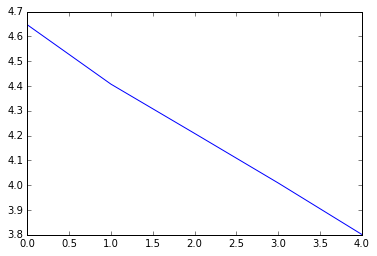

In [71]:
plt.plot(history.history['val_loss'])